### U-net with simple Resnet Blocks v2, can get 0.80+
* Original version : 
  https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks
        
        
#### update log
1.   Cancel last dropout (seems better)
2.  modify convolution_block, to be more consistant with the standard resent model. 
      * https://arxiv.org/abs/1603.05027
3. Use faster  IOU metric score code,
      * https://www.kaggle.com/donchuk/fast-implementation-of-scoring-metric
4. Use  binary_crossentropy loss and then Lovász-hinge loss (very slow!)
     * Lovász-hinge loss: https://github.com/bermanmaxim/LovaszSoftmax
     
Limit the max epochs number to make the kernel finish in the limit of 6 hours, better score can be achived at more epochs 

In [1]:
import os
import sys
import random
from keras.preprocessing import image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()
from models.model_factory import make_model
from models.metrics import my_iou_metric_2
from models.losses import lovasz_loss
from dataset.tsg_data import TSGSaltDataset

/home/pkovacs/anaconda3/envs/exp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
version = 5
basic_name = 'best_resnet_34'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

best_resnet_34.model
best_resnet_34.csv


In [3]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("./train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [4]:
target_size = 101
dataset = TSGSaltDataset(train_data_path='/home/pkovacs/tsg/data/train', val_data_path='/home/pkovacs/tsg/data/val', batch_size=1, seed=2)
train_data_generator = dataset.get_train_data_generator(x_target_size=(target_size, target_size),
                                                            mask_target_size=(target_size, target_size))
val_data_generator = dataset.get_val_data_generator(x_target_size=(target_size, target_size),
                                                        mask_target_size=(target_size, target_size))

Found 3400 images belonging to 1 classes.
Found 3400 images belonging to 1 classes.
Found 600 images belonging to 1 classes.
Found 600 images belonging to 1 classes.


In [5]:
save_model_name = 'best_resnet_34.model'

model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})



In [6]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [7]:
preds_valid = []
y_valid = []
for i in tqdm_notebook(range(600)):
    next_image = next(val_data_generator)
    y_valid.append(next_image[1])
    preds_valid.append(model.predict(next_image[0]))
preds_valid = np.squeeze(np.array(preds_valid))
y_valid = np.squeeze(np.array(y_valid))

In [8]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)



In [9]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.9, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.71716667 0.71766667 0.71783333 0.71983333 0.7215     0.72166667
 0.72216667 0.7225     0.72266667 0.72266667 0.723      0.72333333
 0.72283333 0.7225     0.72333333 0.72266667 0.72283333 0.7215
 0.72066667 0.71983333 0.71883333 0.717      0.38833333 0.38833333
 0.38833333 0.38833333 0.38833333 0.38833333 0.38833333 0.38833333
 0.38833333]


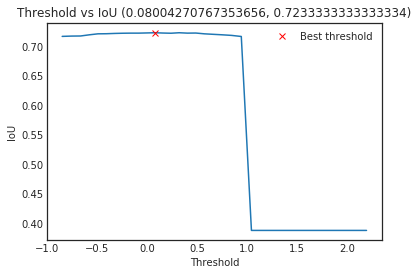

In [10]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [11]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [12]:
test_gen = image.ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True)
test_iter = test_gen.flow_from_directory('data/test/images',
                                         batch_size=1,
                                         target_size=(101, 101), class_mode=None,seed=1, shuffle = False)

Found 18000 images belonging to 1 classes.


In [13]:
filenames = test_iter.filenames
nb_samples = len(filenames)
predictions = model.predict_generator(test_iter,steps = nb_samples, verbose=1)

18000/18000 [==============================] - 126s 7ms/step


In [17]:

t1 = time.time()
pred_dict = {idx[5:-4]: rle_encode(np.round(predictions[i]) > threshold_best) for i, idx in enumerate(tqdm_notebook(filenames))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 1.8082904815673828 s


In [18]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [19]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 0.07931556754642062 hours
